In [1]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures

using CSV, DelimitedFiles, DataFrames
using JLD2
using PlotlyJS


In [2]:
splg_methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS", # requires computing exact leverage scores
    "iid JL-LS",
    #"iid LS", # requires computing exact leverage scores
    "ST JL-LS",
    # "ST LS", # requires computing exact leverage scores
]

# simulation parameters
n_batch = 6; # maximum batch size considered
n_rep = 3; # number of runs

## Combinatorial Laplacian with random graphs

$q=0.1$

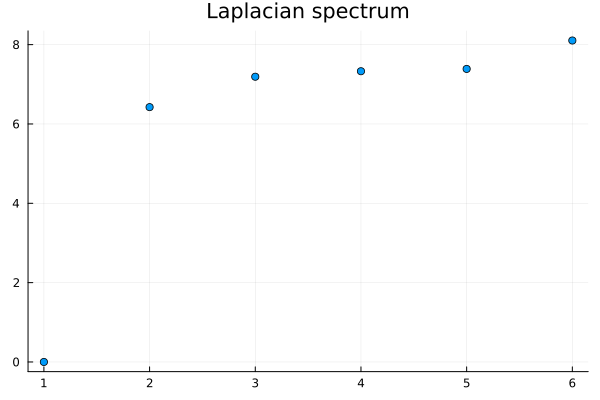

In [4]:
rng = Random.default_rng()

# connection graph parameters
n = 2000
p = 0.01
eta = 0.


# simple ER graph
meta_g = gen_graph_mun(rng, n, p, eta)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

### plotting Laplacian spectrum
B = sp_magnetic_incidence(meta_g)
Lap = B' * B
Lap = 0.5 * (Lap + Lap')
least_eigs,_ = eigs(Lap; nev=6, which=:SM)
println(least_eigs)

Plots.scatter(1:6,sort(real.(least_eigs));legend=false,title="Laplacian spectrum")

In [5]:
least_eigs

6-element Vector{ComplexF64}:
 -1.1191048088221425e-16 + 2.1648763852128748e-33im
      6.4244404095641245 + 5.8882584156650796e-5im
       7.190881136382512 + 0.0009037998112465329im
       7.329530172483573 - 0.003662287555175036im
        7.38787482982178 - 0.0019159539111152058im
       8.103951902319979 + 0.000295452067648838im

In [18]:
# regularization parameter
q = 0.1 #0.001 good one

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)

# plotting
y_limits = (1,1e6)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# # saving plot
name = "precond"*"ER"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
Plots.savefig("figures/"*name*".pdf")


cond nb of Laplacian: 7.392194308452984e16
k = 

401 vs nb edges= 19854
 
k = 

401 vs nb edges= 19854
 
method: DPP(K) unifmethod: 

DPP(K) JL-LS

InterruptException: InterruptException:

$q= 0.001$

In [ ]:
rng = Random.default_rng()

# connection graph parameters
n = 2000
p = 0.01
eta = 0.
# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# simple ER graph
meta_g = gen_graph_mun(rng, n, p, eta)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

cond nb of Laplacian: 36763.899705059055
k = 

402 vs nb edges= 20183
 
k = 

402 vs nb edges= 20183
 
method: DPP(K) unifmethod: 

DPP(K) JL-LSmethod: 

iid JL-LSmethod: 

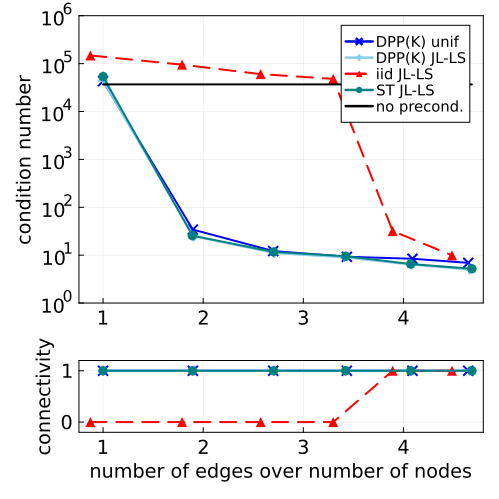

ST JL-LS

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/precondERn2000p0.01eta0.0q0.001.pdf"

In [19]:
# regularization parameter
q = 0.001 

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)

# plotting
y_limits = (1,1e6)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# # saving plot
name = "precond"*"ER"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
Plots.savefig("figures/"*name*".pdf")

In [7]:
name = "nb_roots_ER"*string(q)

#q = 0.001
q = 0.1
nb_samples = 200
nb_roots = zeros(nb_samples)
for i_sample in 1:nb_samples
    mtsf = multi_type_spanning_forest(rng, meta_g, q)
    nb_roots[i_sample] = length(get_prop(mtsf, :roots))
end    

In [8]:
name = "nb_roots_ER"*string(q)

#labels = string.(sort(unique(Int.(nb_roots))))
cat_nb_roots = string.(sort(Int.(nb_roots)))
trace = PlotlyJS.histogram(x=cat_nb_roots, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p,"figures/"*name*".pdf")

"figures/nb_roots_ER0.1.pdf"

## Magnetic Laplacian with random graphs

MUN graph model

cond nb of Laplacian: 801.4513734758522
k = 

397 vs nb edges= 19628
 
k = 

397 vs nb edges= 19628
 
method: DPP(K) unifmethod: 

DPP(K) JL-LSmethod: 

iid JL-LSmethod: 

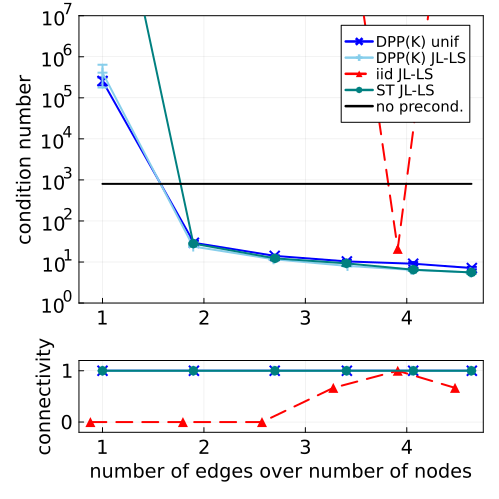

ST JL-LS

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/precondMUNn2000p0.01eta0.1q0.pdf"

In [38]:
type = "MUN" 

rng = Random.default_rng()

# connection graph parameters
n = 2000
p = 0.01
eta = 1e-1

# regularization parameter
q = 0

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# planted ranking score
planted_score = randperm(rng,n)

# graph model
meta_g = MetaGraph(n)

if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng; q_system=1e-13,splg_methods)
name = "precond"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

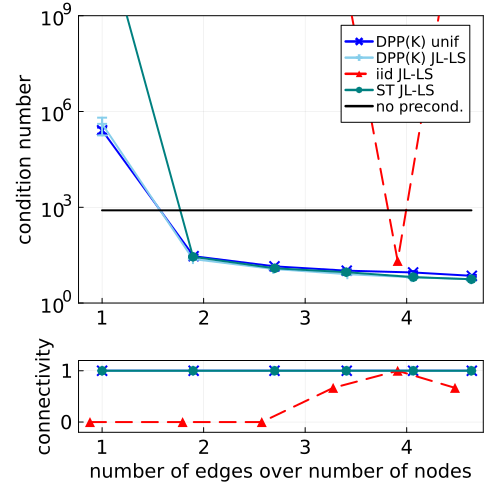

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/precondMUNn2000p0.01eta0.1q0.pdf"

In [39]:
# plotting
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# # saving plot
Plots.savefig("figures/"*name*".pdf")

In [12]:
nb_samples = 200
nb_cycles = zeros(nb_samples)
for i_sample in 1:nb_samples
    mtsf = multi_type_spanning_forest(rng, meta_g, q)
    cycles = get_prop(mtsf, :cycle_nodes)
    nb_cycles[i_sample] = length(cycles)
end    


name = "nb_cycles_MUN_precond_"*type*string(eta)

cat_nb_cycles = string.(sort(Int.(nb_cycles)))
trace = PlotlyJS.histogram(x=cat_nb_cycles, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p,"figures/"*name*".pdf")


"figures/nb_cycles_MUN_precond_MUN0.001.pdf"

ERO graph model

least eigenvalue of Laplacian: 0.0005811063627036751
k = 

397 vs nb edges= 19891
 
k = 

397 vs nb edges= 19891
 
method: DPP(K) unifmethod: 

DPP(K) JL-LSmethod: 

iid JL-LSmethod: 

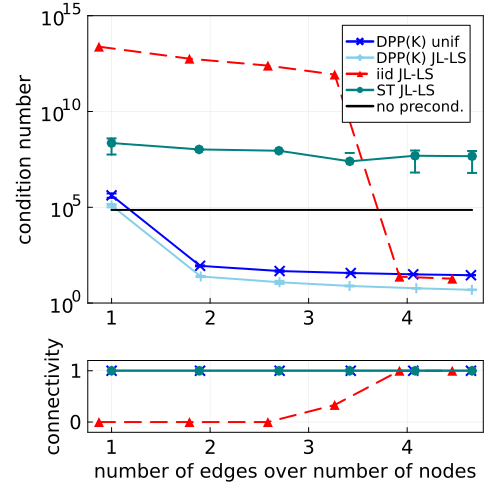

ST JL-LS

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [39]:
type = "ERO" 

rng = Random.default_rng()

# connection graph parameters
n = 2000 
p = 0.01 
eta =  1e-4 

# regularization parameter
q = 0

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# planted ranking score
planted_score = randperm(rng,n)

# graph model
meta_g = MetaGraph(n)

if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng; q_system=1e-13,splg_methods)
name = "precond"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# # saving results
# save("figures/"*name*"_data.jld", "D_results", D_results,"D_params", D_params)

# # saving plot
y_limits = (1,1e15)

name = "precond"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# Plots.savefig("figures/"*name*".pdf")

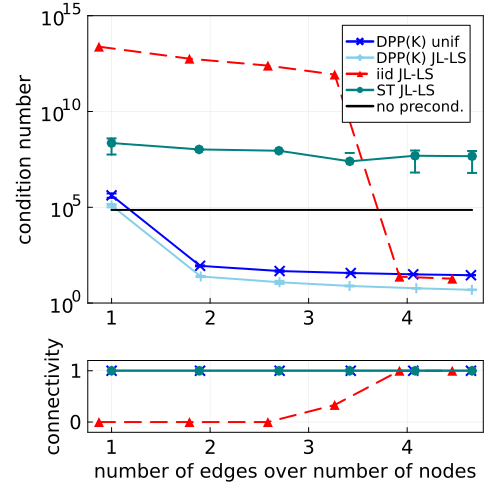

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/precondEROn2000p0.01eta0.0001q0.pdf"

In [40]:
# # saving plot
y_limits = (1,1e15)

name = "precond"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

Plots.savefig("figures/"*name*".pdf")

In [15]:
nb_samples = 200
nb_cycles = zeros(nb_samples)
for i_sample in 1:nb_samples
    mtsf = multi_type_spanning_forest(rng, meta_g, q)
    cycles = get_prop(mtsf, :cycle_nodes)
    nb_cycles[i_sample] = length(cycles)
end    

name = "nb_cycles_"*type*string(eta)

cat_nb_cycles = string.(sort(Int.(nb_cycles)))
trace = PlotlyJS.histogram(x=cat_nb_cycles, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p,"figures/"*name*".pdf")


InterruptException: InterruptException: